In [3]:
import tensorflow as tf
#import utils as utils
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,cross_val_score

In [4]:
data_folder = '../ML4DQM/data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])
datasampleshape=data_sample.shape


In [5]:
datasampleshape

(999, 72, 84)

In [6]:
def killregion(image,xdim,ydim):  
    tempX=image.copy()
    x1=np.min(xdim)
    x2=np.max(xdim)
    y1=np.min(ydim)
    y2=np.max(ydim)
    if x1==x2 | y1==y2:
        print "error, no change is made on image"
    #if tempX.ndim ==3:
    #    
    #    for k in range(tempX.shape[0]):
    #        
    #        for i in range(x1,x2):
    #            
    #            for j in range(y1,y2):
    #                
    #                tempX[k,j,i]=0
    #
    #else:
        
    for i in range(x1,x2):
            
        for j in range(y1,y2):
                
            tempX[j,i]=0
                
    return tempX


#help (np.zeros)
def hotregion(image,xdim,ydim):  
    tempX=image.copy()
    x1=np.min(xdim)
    x2=np.max(xdim)
    y1=np.min(ydim)
    y2=np.max(ydim)
    if x1==x2 | y1==y2:
        print "error, no change is made on image"
   # if tempX.ndim ==3:
   #     
   #     for k in range(tempX.shape[0]):
   #         
   #         for i in range(x1,x2):
   #             
   #             for j in range(y1,y2):
   #                 
   #                 tempX[k,j,i]=np.max(image)
   # else:
        
    for i in range(x1,x2):
            
        for j in range(y1,y2):
                
            tempX[j,i]=np.max(image)
                
    return tempX

def randomregion(image,xdim,ydim):
    
    
    tempX=image.copy()
    x1=abs(np.min(xdim))
    x2=np.max(xdim)
    y1=abs(np.min(ydim))
    y2=np.max(ydim)
    if x1==x2 | y1==y2:
        print "error, no change is made on image"
    #print "x1,x2,y1,y2",x1,x2,y1,y2
    random_noise_region=np.random.randint(np.max(image), size=( abs(x2-x1), abs(y2-y1) ) )   
    #print "random_noise_region.shape",random_noise_region.shape
    

  #  if tempX.ndim == 3:
  #      
  #      for k in range(tempX.shape[0]):
  #          
  #          for i in range(x1,x2):
  #              
  #              for j in range(y1,y2):
  #                  te = i-x1
  #                  te2= j-y1
  #                  tempX[k,j,i]=random_noise_region[te,te2]
  #  
  #  else:
  #      
    for i in range(x1,x2):
            
        for j in range(y1,y2):
            te = i-x1
            te2= j-y1
            tempX[j,i]=random_noise_region[te,te2]
                
    return tempX

Shape of regular image is:  (100, 72, 84)
Shape of dead image is:  (100, 72, 84)
Shape of hot image is:  (100, 72, 84)
Shape of random image is:  (100, 72, 84)

max of image is:  2020.0


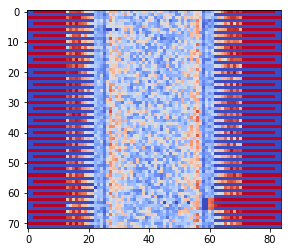

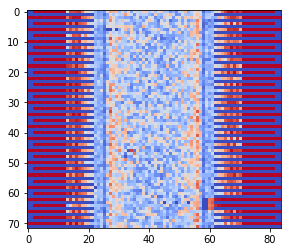

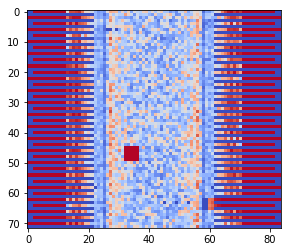

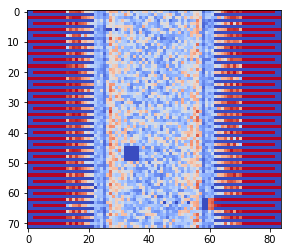

In [7]:
input_images=data_sample[:100]
hotregion_image=[]
deadregion_image=[]
random_image=[]
count=0
for k in input_images:
    a=np.random.randint(datasampleshape[2]-24)
    b=np.random.randint(datasampleshape[1]-5)
    xdim=(a,a+5)
    ydim=(b,b+5)
    hotregion_image.append( hotregion(k,xdim,ydim))
    deadregion_image.append(killregion(k,xdim,ydim))
    random_image.append(randomregion(k,xdim,ydim))
    #print "xdim,ydim:",xdim,ydim
    #print count
    count+=1
    
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)
random_image=np.array(random_image)
#print "xdim,ydim",xdim,ydim
print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape
print "Shape of random image is: " ,random_image.shape

print '\nmax of image is: ' ,np.max(input_images)

im=plt.imshow(input_images[4],cmap=cm.coolwarm)
plt.show()
plt.clf()


im=plt.imshow(random_image[4],cmap=cm.coolwarm)
plt.show()
plt.clf()

im=plt.imshow(hotregion_image[4],cmap=cm.coolwarm)
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

im=plt.imshow(deadregion_image[4],cmap=cm.coolwarm)
plt.show()
plt.clf()
#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


In [8]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
sample= np.append(sample,random_image,axis=0)            


In [9]:
print sample.shape

(1299, 72, 84)


In [10]:
sample=np.reshape(sample,(sample.shape[0],
                          sample.shape[1]*sample.shape[2] ) )
sample.shape

(1299, 6048)

Add the labels at the last column

In [11]:
sample=np.append(sample,np.ones((sample.shape[0],1)),axis=1 )
sample.shape

(1299, 6049)

In [12]:
sample[-3*input_images.shape[0]:,-1:]=0

# Now to create and train a model

In [13]:
import scipy as sp
from sklearn.neural_network import MLPClassifier,multilayer_perceptron #MLPClassifier takes too long
from sklearn import metrics
#from sklearn.grid_search import RandomizedSearchCV,GridSearchCV
#from scipy import stats

X=sample[:,:-1]
y=sample[:,-1]
print "X shape is: ",X.shape
print "y shape is: ",y.shape


Xtrain,Xtest,ytrain, ytest=train_test_split(X,y,test_size=.4)#,random_state =5 )

print Xtrain.shape
print Xtest.shape
print ytrain.shape
print ytest.shape

X shape is:  (1299, 6048)
y shape is:  (1299,)
(779, 6048)
(520, 6048)
(779,)
(520,)


Since MLP is sensitive to feature scaling we will scale the data down and then train it

In [14]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(Xtrain)  
Xtrain = scaler.transform(Xtrain)  
# apply same transformation to test data
Xtest = scaler.transform(Xtest)  

In [15]:
nn= MLPClassifier(hidden_layer_sizes=(650,4))#activation='logistic',solver='sgd',learning_rate='adaptive')

In [16]:
scores= cross_val_score(nn,X,y,cv=10,scoring='accuracy').mean()
print scores

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/2.7.13-b163d/x86_64-slc6-gcc62-opt/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/2.7.13-b163d/x86_64-slc6-gcc62-opt/lib/python2.7/inspect.py", line 1008, in getframein

IndexError: string index out of range

In [17]:
nn.fit(Xtrain,ytrain)
pred=nn.predict(Xtest)
print pred.shape
print metrics.accuracy_score(ytest,pred)

(520,)
0.663461538462


In [18]:
#calcualte null accuracy
print 'null accuracy', max(ytest.mean(),1-ytest.mean())
#Confusion matrix
print metrics.confusion_matrix(ytest,pred)
#save confusion matrix and slice into 4 pieces
confusion= metrics.confusion_matrix(ytest,pred)
TP=confusion[1,1]
TN=confusion[0,0]
FP=confusion[0,1]
FN=confusion[1,0]

print "True Pos:",TP
print "True Neg:",TN
print "False Pos:",FP
print "False Neg:",FN



null accuracy 0.782692307692
[[113   0]
 [175 232]]
True Pos: 232
True Neg: 113
False Pos: 0
False Neg: 175


In [19]:
#Clasification Accuracy
#how often is the Clf correct?
print 'Clasification Accuracy'
print (TP+TN)/ float(TP+TN+FP+FN)
print metrics.accuracy_score(ytest,pred)


#Clasification Error
# how often is it incorrect?
print 'Clasification Error'
print (FP+FN)/ float(TP+TN+FP+FN)
print 1- metrics.accuracy_score(ytest,pred)


#Sensitivity
# How often if the prediction correct when the actual value is pos. 
#AKA True pos or Recall
print 'Sensitivity or Recall'
print TP/ float(TP+FN)
print metrics.recall_score(ytest,pred)


#Specificity 
# When the actual result is neg how often is it correct?
print 'Specificity'
print TN/ float(TN+FP)

#false positive rate
# When the actual value is negative how often is it incorrect
print 'False Positive Rate'
print FP/ float(TN+FP)


#Precision
#When a positive value is predicted, how often is it correct?
print 'Precision'
print TP/ float(TP +FP)
print metrics.precision_score(ytest,pred)

Clasification Accuracy
0.663461538462
0.663461538462
Clasification Error
0.336538461538
0.336538461538
Sensitivity or Recall
0.570024570025
0.570024570025
Specificity
1.0
False Positive Rate
0.0
Precision
1.0
1.0


# Adjusting the clasification threshold

In [21]:
#print the first 10 predicted responses
print nn.predict(Xtest)[0:10]

#print the first 10 predicted probabilities of class membership
print nn.predict_proba(Xtest)[0:10,:]

#print the first 10 predicted probabilities for class 1
print nn.predict_proba(Xtest)[0:10,1]

#store the predicted probabilities for class 1
y_pred_prob=nn.predict_proba(Xtest)[:,1]



[ 0.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
[[  5.66017695e-01   4.33982305e-01]
 [  2.52004326e-05   9.99974800e-01]
 [  3.20655150e-08   9.99999968e-01]
 [  4.71496966e-06   9.99995285e-01]
 [  5.66017695e-01   4.33982305e-01]
 [  3.48863617e-06   9.99996511e-01]
 [  3.16744152e-06   9.99996833e-01]
 [  5.66017695e-01   4.33982305e-01]
 [  1.00083221e-05   9.99989992e-01]
 [  4.41863437e-07   9.99999558e-01]]
[ 0.4339823   0.9999748   0.99999997  0.99999529  0.4339823   0.99999651
  0.99999683  0.4339823   0.99998999  0.99999956]


Text(0,0.5,u'Frequency')

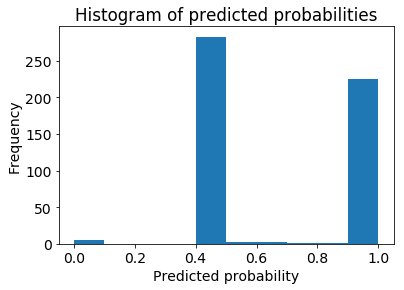

In [22]:
#allow plots to appear in the notebook
%matplotlib inline
plt.rcParams['font.size']=14

#histogram of predicted probabilities
plt.hist(y_pred_prob)#bins=8)
#plt.xlim(0,1)
plt.title("Histogram of predicted probabilities")
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

# Change the threshold 

In [93]:
#predict good if the predicted probability is greater than x
from sklearn.preprocessing import binarize
pred= binarize(y_pred_prob,.433982304999)[0]

#print old confusion matrix
print confusion

#print new confusion matrix
print metrics.confusion_matrix(ytest,pred)

[[113   0]
 [175 232]]
[[113   0]
 [173 234]]


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# ROC Curves and Area Under the Curve (AUC)

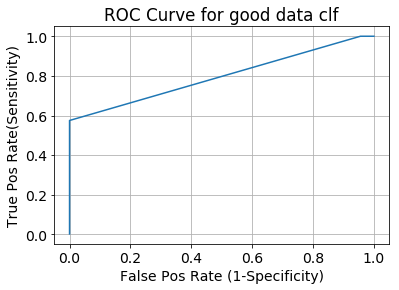

In [94]:
fpr,tpr,thresholds= metrics.roc_curve(ytest,y_pred_prob)
plt.plot(fpr,tpr)
#plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
plt.title('ROC Curve for good data clf')
plt.xlabel('False Pos Rate (1-Specificity)')
plt.ylabel('True Pos Rate(Sensitivity)')
plt.grid(True)

In [95]:
#define a function that accepts a threshold and prints sensitivity and specificity
def evalualte_threshold(threshold):
    print 'Sensitivity:',tpr[thresholds > threshold][-1]
    print 'Specificity:',1- fpr[thresholds > threshold][-1]
    print '------------'

In [97]:
from pylab import linspace
x=linspace(0.43,44)
print x
count=0
for k in x:
    print count
    evalualte_threshold(k)
    count+=1

 [  0.43         1.31918367   2.20836735   3.09755102   3.98673469
   4.87591837   5.76510204   6.65428571   7.54346939   8.43265306
   9.32183673  10.21102041  11.10020408  11.98938776  12.87857143
  13.7677551   14.65693878  15.54612245  16.43530612  17.3244898
  18.21367347  19.10285714  19.99204082  20.88122449  21.77040816
  22.65959184  23.54877551  24.43795918  25.32714286  26.21632653
  27.1055102   27.99469388  28.88387755  29.77306122  30.6622449
  31.55142857  32.44061224  33.32979592  34.21897959  35.10816327
  35.99734694  36.88653061  37.77571429  38.66489796  39.55408163
  40.44326531  41.33244898  42.22163265  43.11081633  44.        ]
0
Sensitivity: 1.0
Specificity: 0.0442477876106
------------
1
Sensitivity:

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# AUC is the percentage of the ROC plot that is under the curve
print metrics.roc_auc_score(ytest,y_pred_prob)

#This is useful as a single number summary of classifier performance    
# Calculate cross validated AUC

cross_val_score(nn,X,y,cv=10,scoring='roc_auc').mean()

0.796873301298
